# 2. Dynamic connectivity calculation
<hr style="height:1px;border:none" />

## Sliding windows
Dynamic connectivity, unlike static connectivity, describe temporally varying connectivity over the duration of an experiment. One popular way to determine dynamic connectivity is by a **sliding windows** method. In a sliding window method, a segment of an fMRI time series data set is extracted (e.g., 45 time points out of 212 time points). The window width is choses so that data points from 60-100s are included in a window. Then a connectivity is calculated based on the extracted time series data. The process is repeated by selecting additional time segments:
  * segment 1: time points 1-45
  * segment 2: time points 2-46
  * segment 3: time points 3-47
  * and so on 

This will results in a number of overlapping segments.


## Tapered windows
A simple sliding window has a *boxcar* shape, giving all time points the same weight. One shortcoming of this approach is that a distant observation at the edge of a window can potentially influence the connectivity. To overcome this problem, it is a common practice to use tapered windows, with distant observations given less weight. Details can be found in Betzel et al. paper.


## Connectivity matrix
Within each window, you can calculate a connectivity matrix describing association between different ROIs. This can be done by calculating a correlation matrix of the weighted data. Another popular approach is to use graphical LASSO to estimate the inverse correlation matrix (a.k.a., ICOV).


## Example
From the Leiden resting-state fMRI data. Here, the window width is 100s or 45 time points. 

`<CalcR.py>`

In [43]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

%matplotlib inline

from pathlib import Path
home_dir = str(Path.home())
work_dir = os.path.join(home_dir, 'Box/CogNeuroLab/Aging Decision Making R01')
data_dir = os.path.join(work_dir, 'Data/Scan/ts_data')

In [2]:
##### Function to extract time series data 
def extract_winTS(X, timeStart, winSize):
    # extracting the window
    winX = X[(timeStart-winSize+1):(timeStart+1)]
    # calculating the weights
    th = winSize / 3
    w0 = (1-np.exp(-1/th))/(1-np.exp(-winSize/th))
    wt = []
    for iT in range(1,winSize+1):
        w = w0 * np.exp((iT - winSize)/th)
        wt.append(w)
    wt = np.array(wt).reshape(winSize,1)
    # weighting with wt
    wwinX = wt * winX
    return wwinX


##### Parameters
TR = 1.5   # TR
nTime = 240  # number of time points
winSizeS = 40  # window width in S
winSizeTR = round(winSizeS / TR) # window width in TR

In [ ]:
##### loading the data
ts_files = os.listdir(data_dir)
infile = np.loadtxt(os.path.join(data_dir, ts_files[0]))
ts = infile
ts_std = StandardScaler().fit_transform(ts)  # scaling the data
nodes = list(range(1,401))
xyz = np.loadtxt(os.path.join(work_dir, 'Analysis/schaefer400/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'), delimiter = ',', skiprows=2, usecols=(2,3,4))
xyz = tuple(map(tuple, schaefer_coords))

In [254]:
##### loading the data
# ts_files = os.listdir(data_dir)
# ts_std_all = np.zeros((240,400))

# for file in sorted(ts_files)[:3]:
#     infile = np.loadtxt(os.path.join(data_dir, ts_files[0]))
#     ts = infile
#     ts_std = StandardScaler().fit_transform(ts)  # scaling the data
#     ts_std_all = np.vstack([ts_std_all, ts_std])

# nodes = list(range(1,401))
# xyz = np.loadtxt(os.path.join(work_dir, 'Analysis/schaefer400/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'), delimiter = ',', skiprows=2, usecols=(2,3,4))
# xyz = tuple(map(tuple, schaefer_coords))

The original time series data is standardized by the **`StandardScaler`** from Scikit-learn so that all variables have zero mean and unit variance.

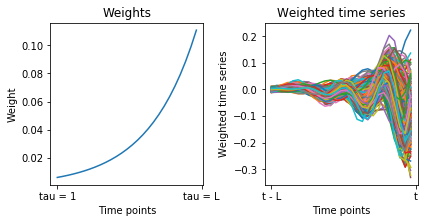

In [63]:
##### plotting the weight and weighted data
# calculating weights
th = winSizeTR / 3
w0 = (1-np.exp(-1/th))/(1-np.exp(-winSizeTR/th))
wt = []
for iT in range(1,winSizeTR+1):
    w = w0 * np.exp((iT - winSizeTR)/th)
    wt.append(w)
wt = np.array(wt).reshape(winSizeTR,1)

# extracting weighted time series
wts = extract_winTS(ts_std, winSizeTR, winSizeTR)

# plotting them 
plt.figure(figsize=[6,3])
plt.subplot(121)
plt.plot(wt)
plt.xlabel('Time points')
plt.xticks([0,winSizeTR],['tau = 1', 'tau = L'])
plt.ylabel('Weight')
plt.title('Weights')

plt.subplot(122)
for iNode in range(len(nodes)):
    plt.plot(wts[:,iNode])
plt.xlabel('Time points')
plt.xticks([0,winSizeTR],['t - L', 't'])
plt.ylabel('Weighted time series')
plt.title('Weighted time series')

plt.subplots_adjust(left=0.125, right=0.975, 
                    bottom=0.15, top=0.90, wspace=0.4)
plt.show()

Here, the left panel shows the shape of the tapered window used in this calculation. The right panel shows the time series data weighted with the tapered weights. Based on these weighted data, a correlation matrix is calculated. 

There are 212 time points in the original fMRI data, and each window contains 45 time points. Thus it is possible to form 167 windows -- thus 167 correlation matrices. Those correlation matrices are stored in an `.npz` file to be used later.

In [64]:
###### Calculating correlation across windows
Rmat = []
for iTime in range(winSizeTR,nTime):
    # extracting weighted time series
    wts = extract_winTS(ts_std, iTime, winSizeTR)
    # correlation matrix
    R = np.corrcoef(wts, rowvar=False)
    # zeroing the main diagonal
    for i in range(R.shape[0]):
        R[i,i] = 0
    # keeping R
    Rmat.append(R)

Rmat = np.array(Rmat)

In [65]:
###### Saving the Rmat for future use
np.savez(os.path.join(work_dir, 'Analysis/dyconn/dFC'),
         Rmat = Rmat,
         winSize = winSizeTR,
         nodes = nodes,
         xyz = xyz)

# 3. Temporal dynamics of network property
<hr style="height:1px;border:none" />

Now we have a series of correlation matrices. We form networks at each time point (i.e., each correlation matrix) with target average degree of 20. Then we will examine how network properties changes over time. To do so, we calculate the local and global efficiencies at each node over time. Unfortunately `networkx` does not allow calculation of efficiencies at the nodal-level, I have written some functions to calculate efficiencies at nodal levels (**`eloc_node`** and **`eglob_node`**; see the code below).

`<Efficiency.py>`

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

###### Network construction functions, based on correlation matrix
def net_builder_HardTh(R, NodeInd, K, cType=1):
    '''
    a function to construct the network by the hard-thresholding.
    input parameters:
          R:         A dense correlation matrix array.
          NodeInd:   A list of nodes in the network.
          K:         The target K, the average connections at each node
          cType:     Type of functional connectivity. 
                        1:  Positive correlation only
                        0:  Both positive and negative correlations
                        -1: Negative correlation only
                     The default is 1 (i.e., positive correlation only).
    
    returns:
          G:         The resulting graph (networkX format)
    '''
    
    # first, initialize the graph
    G = nx.Graph()
    G.add_nodes_from(NodeInd)
    NNodes = R.shape[0]
    # upper triangle of the correlation matrix only
    I,J = np.triu_indices(NNodes,1)
    # creating a vector of correlation coefficients, depending on cType
    if cType==1:
        VecR = np.squeeze(np.array(R[I,J]))
    elif cType==0:
        VecR = np.squeeze(np.array(abs(R[I,J])))
    elif cType==-1:
        VecR = np.squeeze(np.array(-R[I,J]))
    # the number of elements is too big, so we truncate it
    # first, find the appropriate threshold for R
    NthR = 0
    tmpRth = 0.95
    StepTh = 0.05
    while NthR<K*NNodes/2.0:
        tmpRth -= StepTh
        #print('Threshold = %.2f' % tmpRth)
        NthR = len(np.nonzero(VecR>tmpRth)[0])
    # second, truncate the variables
    IndVecR = np.nonzero(VecR>tmpRth)
    thVecR = VecR[IndVecR]
    thI = I[IndVecR]
    thJ = J[IndVecR]
    # sort the correlation values
    zipR = zip(thVecR, thI, thJ)
    zipsR = sorted(zipR, key = lambda t: t[0], reverse=True)
    sVecR, sI, sJ = zip(*zipsR)
    # then adding edges
    m = int(np.ceil(K*NNodes/2.0))  # the number of edges
    trI = np.array(sI[:m])
    trJ = np.array(sJ[:m])
    Elist = np.vstack((NodeInd[trI], NodeInd[trJ])).T
    G.add_edges_from(Elist)
    RTh = sVecR[m-1]  # the threshold
    # finally returning the resultant graph and the threshold
    return G


####### functions to calculate nodal local efficiencies
def eloc_node(G, xNode):
    '''
    A function to calculate the nodal local efficiency
    from a node xNode.
    
    input parameters:
          G:      A graph in networkX format.
          xNode:  The node where the nodal global efficiency is calculated.
    returns:
          Eloc:   The nodal local efficiency at node xNode.
    '''

    subG = subgraph(G, xNode)
    #Eloc, tmpEloci, tmpNodes = eglob_net(subG)
    NNodes = len(subG.nodes())
    if NNodes>1:
        #Dij = nx.all_pairs_shortest_path_length(subG)
        Dij = nx.floyd_warshall(subG)
        D = [Dij[i].values() for i in subG.nodes()]
        cD = []
        for irow in D:
            cD += irow            
        NZD = np.array(cD)[np.nonzero(cD)]
        if len(NZD)>0:
            Eloc = (1.0/(NNodes*(NNodes-1.0))) * np.sum(1.0/NZD)
        else:
            Eloc = 0
    else:
        Eloc = 0
    return Eloc

def subgraph(G, xNode):
    ''''
    A function to extract a subgraph of a node xNode
    
    input parameters:
          G:      A graph in networkX format.
          xNode:  The node where the nodal global efficiency is calculated.
    returns:
          subG:   A subgraph of G, containing neighbors of xNode but not xNode
                  itself.
    '''
    subNodes = list(nx.all_neighbors(G, xNode))
    Edges = G.edges()
    subEdges = []       #create list of subgraph edges
    for iEdge in Edges:
        if (iEdge[0] in subNodes and iEdge[1] in subNodes):
            subEdges.append(iEdge)
    subG = nx.Graph()             # create subgraph
    subG.add_nodes_from(subNodes)    #populate subgraph with nodes
    subG.add_edges_from(subEdges)    # populate subgraph with edges
    return subG

def eglob_node(G, xNode):
    '''
    A function to calculate the nodal global efficiency
    from a node.
    input parameters:
          G:      A graph in networkX format.
          xNode:  The node where the nodal global efficiency is calculated.
    
    returns:
          Eglob:  The nodal blobal efficiency at xNode.
    '''

    NNodes = len(G.nodes())
    Dx = list(nx.single_source_shortest_path_length(G, xNode).values())
    indZ = np.nonzero(np.array(Dx)==0)[0]
    nzDx = np.delete(Dx, indZ)
    if len(nzDx)>0:
        Eglob = (1.0/(NNodes-1.0)) * np.sum(1.0/nzDx)
    else:
        Eglob = 0
    # returning the nodal global efficiency
    return Eglob




##### Parameters
targetDeg = 20

##### Loading the data
infile = np.load(os.path.join(work_dir, 'Analysis/dyconn/dFC.npz'))
Rmat = infile['Rmat']
nodes = infile['nodes']
xyz = infile['xyz']

In [68]:
Rmat.shape[0]

213

Here is a loop to construct a network and calculate nodal local and global efficiencies at each time point.

In [67]:
###### Loop over time points
ElocMat = np.zeros((len(nodes),Rmat.shape[0]))
EglobMat = np.zeros((len(nodes),Rmat.shape[0]))
for iTime in range(Rmat.shape[0]):
    print('Working on time point %d' % iTime)

    ###### extracting a network 
    G = net_builder_HardTh(Rmat[iTime,:,:], nodes, targetDeg)

    ###### calculating local and global efficiency
    ElocList = []
    EglobList = []
    for iNode in nodes:
        Eloc = eloc_node(G,iNode)
        ElocList.append(Eloc)
        Eglob = eglob_node(G,iNode)
        EglobList.append(Eglob)

    # saving it for later
    ElocMat[:,iTime] = ElocList
    EglobMat[:,iTime] = EglobList

##### saving to a file so that we don't have to recalculate
np.savez(os.path.join(work_dir, 'Analysis/dyconn/dFC_Efficiency.npz'),
         ElocMat = ElocMat,
         EglobMat = EglobMat,
         nodes = nodes,
         xyz = xyz)

Working on time point 0
Working on time point 1
Working on time point 2
Working on time point 3
Working on time point 4
Working on time point 5
Working on time point 6
Working on time point 7
Working on time point 8
Working on time point 9
Working on time point 10
Working on time point 11
Working on time point 12
Working on time point 13
Working on time point 14
Working on time point 15
Working on time point 16
Working on time point 17
Working on time point 18
Working on time point 19
Working on time point 20
Working on time point 21
Working on time point 22
Working on time point 23
Working on time point 24
Working on time point 25
Working on time point 26
Working on time point 27
Working on time point 28
Working on time point 29
Working on time point 30
Working on time point 31
Working on time point 32
Working on time point 33
Working on time point 34
Working on time point 35
Working on time point 36
Working on time point 37
Working on time point 38
Working on time point 39
Working on

But it takes a few minutes to run, so I just load the *pre-cooked* results.

In [6]:
##### loading from the file to save time
f = np.load(os.path.join(work_dir, 'Analysis/dyconn/dFC_Efficiency.npz'))
ElocMat = f['ElocMat']
EglobMat = f['EglobMat']
nodes = f['nodes']
xyz = f['xyz']

And let's plot the efficiencies over time.

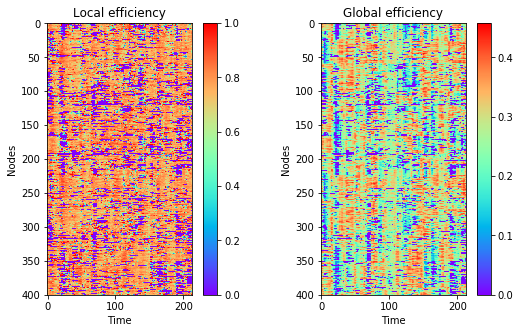

In [70]:
##### plotting efficiency over time
plt.figure(figsize=[9,5])
plt.subplot(121)
plt.imshow(ElocMat, cmap=plt.cm.rainbow)
plt.title('Local efficiency')
plt.xlabel('Time')
plt.ylabel('Nodes')
plt.colorbar()

plt.subplot(122)
plt.imshow(EglobMat, cmap=plt.cm.rainbow)
plt.title('Global efficiency')
plt.xlabel('Time')
plt.ylabel('Nodes')
plt.colorbar()

plt.show()

Here, rows represent different nodes, and columns represent time. As you can see, there are some time points where efficiencies change dramatically (manifesting as a vertical *edge*, more apparent in global efficiency).

# 4. Brain states
<hr style="height:1px;border:none" />

So, there seems to be system-wide changes occurring at different points during this experiment. In fact, so-called resting-state is made up of distinct states with similar connectivity patters. These states are discrete, and transitions from one state to another in a short period of time.

We can identify different brain states by K-means clustering, an unsupervised machine learning method. 

## K-means clustering
K-means clustering is a machine learning method that groups observations into K distinct groups according to their similarities. Here, we cluster time points into different clusters of similar connectivity patterns. To do so, we re-organize the correlation matrix at each time  point into a single vector.

`<Clustering.py>`

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

####### Loading the data
infile = np.load(os.path.join(work_dir, 'Analysis/dyconn/dFC.npz'))
Rmat = infile['Rmat']
nNodes = Rmat.shape[-1]
nTime = Rmat.shape[0]
indR = np.triu_indices(nNodes,1) # indices for the upper triangle of R
# initializing the data array, rows = correlation, cols = time
Rdata = np.zeros((nTime,len(indR[0])))
for iTime in range(nTime):
    R = Rmat[iTime,:,:]
    Rdata[iTime,:] = R[indR]

### Determining K
One downside of K-means clustering is that you have to know K, the number of clusters, before you run the clustering algorithm. If K is unknown, then you have to estimate K. One way to do this is by generating a **Scree plot**. In particular, we perform K-means clustering with different values of K. Then plot the squared sum of distances between the cluster centroid and observations (known as inertia) over K.

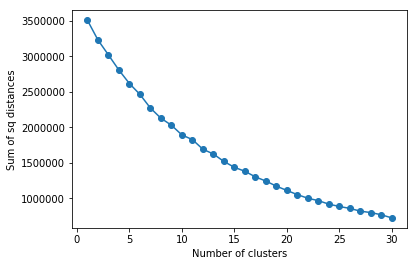

In [72]:
###### Clustering --- Figuring out the  number of clusters
# determinging the number of clusters (up to 30 clusters)
SSE = []
for iClus in range(1,31):
    #print('Number of clusters: %d' % iClus)
    # K-means clustering
    km = KMeans(n_clusters=iClus)  # K-means with a given number of clusters
    km.fit(Rdata)  # fitting the principal components
    SSE.append(km.inertia_) # recording the sum of square distances

# plotting the sum of square distance
plt.plot(np.arange(1,31),SSE,marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('Sum of sq distances')
plt.show()

Once you have a Scree plot, you look for an **elbow**. The elbow is defined as the point where  the rate of decrease stabilizes. This criterion is somewhat subjective. In our case, we will go with K=6 as the elbow. 

### Running K-means clustering

In [73]:
###### Clustering --- with K=6
km = KMeans(n_clusters=6)  # defining the clustering object
km.fit(Rdata)  # actually fitting the data
y_clus = km.labels_   # clustering info resulting from K-means
y_cent = km.cluster_centers_  # centroid coordinates

We have cluster assignments stored in an array **`y_clus`**. We can plot `y_clus` and the global efficiency over time. 

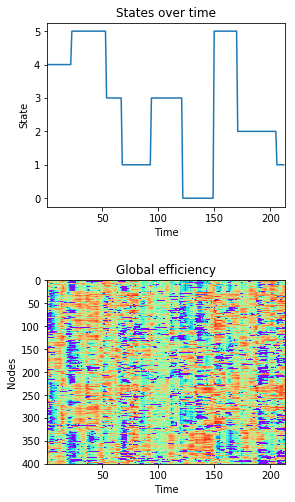

In [75]:
####### plotting cluster over time
f = np.load(os.path.join(work_dir, 'Analysis/dyconn/dFC_Efficiency.npz'))
EglobMat = f['EglobMat']
xyz = f['xyz']
nodes = f['nodes']
plt.figure(figsize=[4,7])
plt.subplot(211)
plt.plot(y_clus)
plt.title('States over time')
plt.xlabel('Time')
plt.ylabel('State')
plt.xlim(1,nTime)

plt.subplot(212)
plt.imshow(EglobMat, cmap=plt.cm.rainbow, aspect='auto')
plt.title('Global efficiency')
plt.xlabel('Time')
plt.ylabel('Nodes')
plt.xlim(1,nTime)

plt.subplots_adjust(left=0.15, right=0.975, top=0.95, bottom=0.075,
                    hspace=0.4)
plt.show()

As you may notice, state changes corresponds to vertical edges in the global efficiency plot.

We shall save the cluster assignment, as well as the cluster centroids (**`y_cent`** for later use.

In [76]:
####### Saving the centroid information
np.savez(os.path.join(work_dir, 'Analysis/dyconn/dFC_cluster.npz'),
         y_clus = y_clus,
         y_cent = y_cent,
         nodes = nodes,
         xyz = xyz)

In [77]:
y_cent.shape

(6, 79800)

## Centroid modules

The centroid for each cluster from K-means clustering represent representative connectivity at that particular brain state. We can transform the centroid back to a connectivity matrix (correlation matrix), generate a network representative of that state, and determine the modular organization for that state.

`<EigenModules.py>`

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


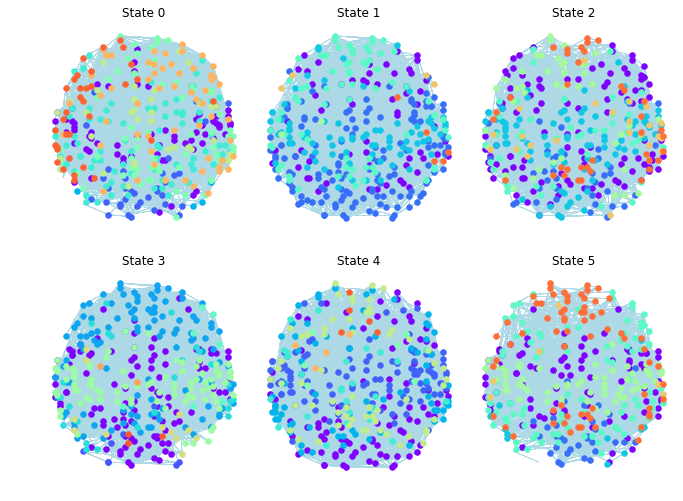

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community   # Louvain method
from sklearn.metrics import adjusted_rand_score


##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


###### Network construction functions, based on correlation matrix
def net_builder_HardTh(R, NodeInd, K, cType=1):
    '''
    a function to construct the network by the hard-thresholding.
    input parameters:
          R:         A dense correlation matrix array.
          NodeInd:   A list of nodes in the network.
          K:         The target K, the average connections at each node
          cType:     Type of functional connectivity. 
                        1:  Positive correlation only
                        0:  Both positive and negative correlations
                        -1: Negative correlation only
                     The default is 1 (i.e., positive correlation only).
    
    returns:
          G:         The resulting graph (networkX format)
    '''
    
    # first, initialize the graph
    G = nx.Graph()
    G.add_nodes_from(NodeInd)
    NNodes = R.shape[0]
    # upper triangle of the correlation matrix only
    I,J = np.triu_indices(NNodes,1)
    # creating a vector of correlation coefficients, depending on cType
    if cType==1:
        VecR = np.squeeze(np.array(R[I,J]))
    elif cType==0:
        VecR = np.squeeze(np.array(abs(R[I,J])))
    elif cType==-1:
        VecR = np.squeeze(np.array(-R[I,J]))
    # the number of elements is too big, so we truncate it
    # first, find the appropriate threshold for R
    NthR = 0
    tmpRth = 0.95
    StepTh = 0.05
    while NthR<K*NNodes/2.0:
        tmpRth -= StepTh
        #print('Threshold = %.2f' % tmpRth)
        NthR = len(np.nonzero(VecR>tmpRth)[0])
    # second, truncate the variables
    IndVecR = np.nonzero(VecR>tmpRth)
    thVecR = VecR[IndVecR]
    thI = I[IndVecR]
    thJ = J[IndVecR]
    # sort the correlation values
    zipR = zip(thVecR, thI, thJ)
    zipsR = sorted(zipR, key = lambda t: t[0], reverse=True)
    sVecR, sI, sJ = zip(*zipsR)
    # then adding edges
    m = int(np.ceil(K*NNodes/2.0))  # the number of edges
    trI = np.array(sI[:m])
    trJ = np.array(sJ[:m])
    Elist = np.vstack((NodeInd[trI], NodeInd[trJ])).T
    G.add_edges_from(Elist)
    RTh = sVecR[m-1]  # the threshold
    # finally returning the resultant graph and the threshold
    return G


####### Loading the cluster data
infile = np.load(os.path.join(work_dir, 'Analysis/dyconn/dFC_cluster.npz'))
y_clus = infile['y_clus']
y_cent = infile['y_cent']
xyz = infile['xyz']
nodes = infile['nodes']
nNode = len(nodes)
nClus = max(y_clus) + 1



####### modules for centroid connectivity
targetDeg = 20
partition_list = []
GC_list = []
for i in np.unique(y_clus):
    # reconstructing the connectivity matrix for the centroid
    R = np.zeros((nNode,nNode))
    indR = np.triu_indices(nNode,1)
    R[indR] = y_cent[i]
    R = R.T
    R[indR] = y_cent[i]
    # Constructing a network based on the centroid conenctivty
    G = net_builder_HardTh(R, nodes, targetDeg)
    # finding the giant component
    GC_nodes = max(nx.connected_components(G), key=len)  
    GC = G.subgraph(GC_nodes)
    GC_list.append(G)
    ###### modular partition by Louvain
    partition = community.best_partition(GC)
    partition_list.append(partition)


###### drawing the graph
# dictionary of xy-coordinates
pos = {}
for iROI in range(len(nodes)):
    pos[nodes[iROI]] = xyz[iROI,:2]

# Loop over states for visualization
plt.figure(figsize=[9,7])
for iState in np.unique(y_clus):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(2,3,iState+1)
    nComm = max([comm for comm in partition_list[iState].values()])+1
    node_color_list = get_cmap(nComm+1,'rainbow')
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[iState].items()
                    if Comm==iComm]
        nx.draw_networkx_nodes(GC_list[iState], pos, 
                               nodelist=nodeList,
                               node_color = np.array([node_color_list(iComm)]),
                               node_size=30)
        nx.draw_networkx_edges(GC_list[iState], pos, width=0.5,
                               edge_color='lightblue')
    plt.title('State %d' % iState)
    plt.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.925)
plt.show()




In [184]:
import pandas as pd
from nilearn import datasets
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir=os.path.join(work_dir, 'Analysis/schaefer400'))
atlas_filename = dataset.maps
labels = dataset.labels

labels_df = pd.DataFrame(labels, columns = ['labels'], dtype=str)
dmn_mask = labels_df.index[labels_df['labels'].str.contains('Default')]
fpn_mask = labels_df.index[labels_df['labels'].str.contains('Cont')]
sal_mask = labels_df.index[labels_df['labels'].str.contains('SalVentAttn')]
dan_mask = labels_df.index[labels_df['labels'].str.contains('DorsAttn')]

In [185]:
dmn_mask

Int64Index([148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
            161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
            174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
            187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
            361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373,
            374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386,
            387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399],
           dtype='int64')

Within-Network Mean FC
State 0
DMN: 0.07583625166042748
FPN: 0.018808114961961116
SAL: 0.014496142155716624
DAN: 0.0009555661729574773


Within-Network Mean FC
State 1
DMN: 0.04359376886849414
FPN: 0.015004226542688081
SAL: 0.008417114800093524
DAN: 0.005255613951266125


Within-Network Mean FC
State 2
DMN: 0.023789397415771043
FPN: 0.013736263736263736
SAL: 0.005377601122281974
DAN: 0.0011944577161968467


Within-Network Mean FC
State 3
DMN: 0.0877913295495713
FPN: 0.040997464074387154
SAL: 0.010755202244563947
DAN: 0.000716674629718108


Within-Network Mean FC
State 4
DMN: 0.08416857867407318
FPN: 0.027895181741335588
SAL: 0.008650923544540565
DAN: 0.001433349259436216


Within-Network Mean FC
State 5
DMN: 0.018476029465040456
FPN: 0.0027472527472527475
SAL: 0.00397474865559972
DAN: 0.002866698518872432




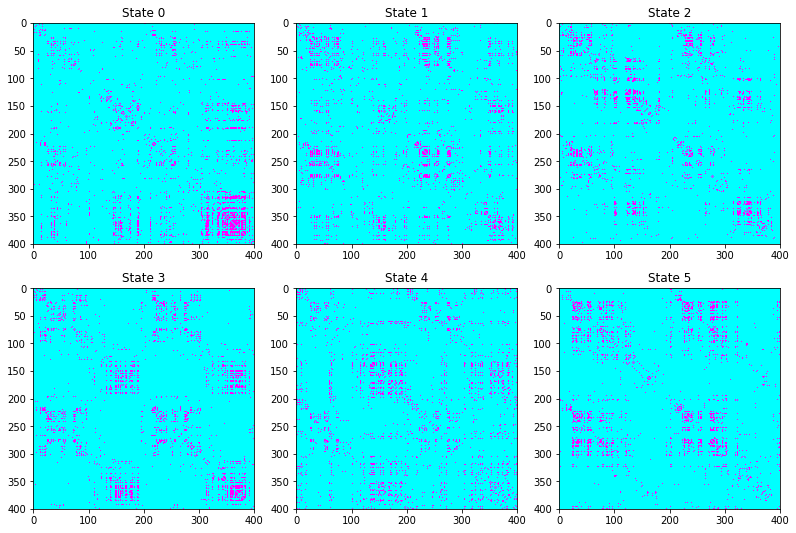

In [222]:
from nilearn import plotting
plt.figure(figsize=(11,10))

for iState in np.unique(y_clus):
    plt.subplot(2,3,iState+1)
    adj = nx.to_numpy_matrix(GC_list[iState])
    plt.imshow(adj, interpolation='None', cmap='cool')
    plt.title('State %d' % iState)
    
    print('Within-Network Mean FC')
    print('State %s' % iState)
    print('DMN: %s' % np.tril(adj[dmn_mask][:,dmn_mask]).mean())
    print('FPN: %s' % np.tril(adj[fpn_mask][:,dmn_mask]).mean())
    print('SAL: %s' % np.tril(adj[sal_mask][:,dmn_mask]).mean())
    print('DAN: %s' % np.tril(adj[dan_mask][:,dmn_mask]).mean())
    print('\n')
    
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.7)

# *Further readings*
<hr style="height:1px;border:none" />

* Allen et al. 2014. Tracking Whole-Brain Connectivity Dynamics in the Resting State. Cerebral Cortex 24:663–676

* Preti et al. 2017. The dynamic functional connectome: State-of-the-art and perspective. NeuroImage 160:41–54

* Zalesky et al. 2014. Time-resolved resting-state brain networks. PNAS 111:10341–10346